In [1]:
import IPython

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


## 15.1 순환 뉴런과 순환 층

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)
    # return series.astype(np.float32)

In [ ]:
n_steps = 50
series = generate_time_series(batch_size=10000, n_steps=n_steps+1)
series.shape

(10000, 51, 1)

NameError: ignored

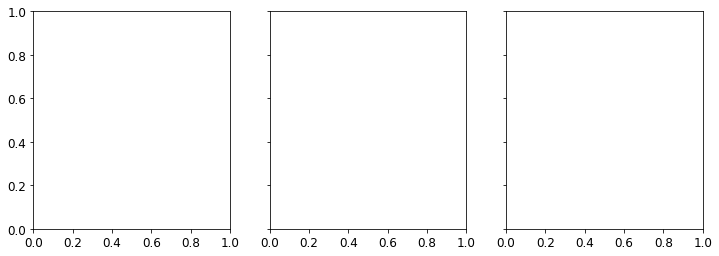

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

In [ ]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[:9000, :n_steps], series[:9000, -1]

In [ ]:
k =0
plt.plot(X_train[k])
plt.scatter(n_steps, y_train[k], c='orange')
plt.show()

### 15.3.1 기준 성능

In [ ]:
class NaiveForecasting(tf.keras.Model):
    def __init__(self):
        super().__init__()

    def __call__(self, inputs):
        y_pred = inputs[:, -1]
        return y_pred

In [ ]:
loss = tf.losses.MeanSquaredError()
model = NaiveForecasting()
model.compile(loss=loss)
# model.fit(x=X_train, y=y_train)
np.mean(keras.losses.mean_squared_error(model(X_valid), y_valid))

In [ ]:
# 순진한 예측 naive forecasting
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

In [ ]:
# 완전 연결 네트워크 fully connected network
model = tf.keras.models.Sequential(name='FCN', layers=[
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='Adam', loss=tf.losses.MeanSquaredError())

In [ ]:
history = model.fit(x=X_train, y=y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))
IPython.display.clear_output()
model.evaluate(X_valid, y_valid)

In [ ]:
plt.plot(history.history['loss'], "b.-", label="training loss")
plt.plot(history.history['val_loss'], "r.-", label="validation loss")

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 15.3.2 간단한 RNN 구현하기

In [ ]:
# model
model = keras.Sequential(name = "SimpleRNN", layers=[
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
    ])
# compile
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
model.compile(loss="mse", optimizer=optimizer)
# fit
history = model.fit(x=X_train, y=y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))
IPython.display.clear_output()
# evaluate
model.evaluate(X_valid, y_valid)

In [ ]:
# predict
k = 3
y_pred = model.predict(X_valid)
plot_series(X_valid[k, :, 0], y_valid[k, 0], y_pred[k, 0])

###15.3.3 심층 RNN

In [ ]:
# SimpleRNN 테스트
rnn = keras.layers.SimpleRNN(1, input_shape=[None, 1], 
                             return_sequences=False)
inputs = np.array([1., 1]).reshape([1, 1, -1])
rnn(inputs)

In [ ]:
# model
model = keras.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [ ]:
# compile
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
model.compile(loss="mse", optimizer=optimizer)
# fit
history = model.fit(x=X_train, y=y_train, epochs=20, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[tf.keras.callbacks.EarlyStopping()])
# IPython.display.clear_output()
# evaluate
model.evaluate(X_valid, y_valid)

In [ ]:
# model
model = keras.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # (batch, nsteps, units)
    keras.layers.Dense(1)
])

In [ ]:
# compile
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
model.compile(loss="mse", optimizer=optimizer)
# fit
history = model.fit(x=X_train, y=y_train, epochs=20, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[tf.keras.callbacks.EarlyStopping()])
# IPython.display.clear_output()
# evaluate
model.evaluate(X_valid, y_valid)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.summary()

###15.3.4 여러 타임 스텝 앞을 예측하기

In [ ]:
series = generate_time_series(1, n_steps+10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    # print(len(X[0, step_ahead:])) # 50
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

#### naive prediction

In [ ]:
np.random.seed(42)
series = generate_time_series(10000, n_steps+10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
X = X_valid
for step_ahead in range(10):
    # 모델 실행
    # y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    # 입력값 수정
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:, 0]

In [ ]:
Y_pred.shape
np.mean(tf.keras.losses.mean_squared_error(Y_valid, Y_pred))

In [ ]:
Y_naive_pred = np.tile(X_valid[:, -1], 10)
np.mean(tf.keras.losses.mean_squared_error(Y_valid, Y_naive_pred))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[50, 1]),
    tf.keras.layers.Dense(10)
])

In [ ]:
# compile
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
model.compile(loss="mse", optimizer="adam")
# fit
history = model.fit(x=X_train, y=Y_train, epochs=20, 
                    validation_data=(X_valid, Y_valid),
                    # callbacks=[tf.keras.callbacks.EarlyStopping()]
                    )
# IPython.display.clear_output()
# evaluate
model.evaluate(X_valid, Y_valid)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(10)
])

In [ ]:
# compile
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
model.compile(loss="mse", optimizer="adam")
# fit
history = model.fit(x=X_train, y=Y_train, epochs=20, 
                    validation_data=(X_valid, Y_valid),
                    # callbacks=[tf.keras.callbacks.EarlyStopping()]
                    )
# IPython.display.clear_output()
# evaluate
model.evaluate(X_valid, Y_valid)

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [ ]:
print([arr.shape for arr in [X_new, Y_new, Y_pred]])

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()